# Tutorial : Classifying Orbit5k with giotto-deep

The Orbit5k dataset consists of a set of 5000 subsets $(S^{\rho_k})_{k = 1...1000}$ of 1000 points of $[0,1]^2$. For a given $\rho \in \{2.5, 3.5, 4.0, 4.1,4.3\}$, each subset $S^\rho \subset [0,1]^2 $ is generated randomly according to the following procedure:

1. Start with a uniformly randomly sampled point $(x_0,y_0)\in [0,1]^2$
2. For $n \geq 1$, generate $(x_{n+1},y_{n+1})$ inductively by : 

$$ x_{n+1} = x_{n} + \rho y_n(1-y_n) ~~~\text{mod }1$$
$$ y_{n+1} = y_{n} + \rho x_n(1-x_n) ~~~\text{mod }1$$

3. Define $S^\rho := \{(x_i,y_i) \mid i = 0...999 \}$

We generate $S^\rho$ 1000 times per values of $\rho$. 

The classification problem is then to recover the parameter $\rho$ from the persistence diagrams of $S^\rho$.



## Import the necessary packages

In [2]:
from dataclasses import dataclass
import os
from typing import Tuple

import torch
import torch.nn as nn
from gdeep.data import PreprocessingPipeline
from gdeep.data.datasets import PersistenceDiagramFromFiles
from gdeep.data.datasets.base_dataloaders import (DataLoaderBuilder,
                                                  DataLoaderParamsTuples)
#from gdeep.data.datasets.persistence_diagrams_from_graphs_builder import \
#    PersistenceDiagramFromGraphBuilder
from gdeep.data.persistence_diagrams.one_hot_persistence_diagram import (
    OneHotEncodedPersistenceDiagram, collate_fn_persistence_diagrams)
from gdeep.data.preprocessors import (
    FilterPersistenceDiagramByHomologyDimension,
    FilterPersistenceDiagramByLifetime, NormalizationPersistenceDiagram)
from gdeep.search.hpo import GiottoSummaryWriter
from gdeep.topology_layers import Persformer, PersformerConfig, PersformerWrapper
from gdeep.topology_layers.persformer_config import PoolerType
from gdeep.trainer.trainer import Trainer
from gdeep.search import HyperParameterOptimization
from gdeep.utility import DEFAULT_GRAPH_DIR, PoolerType
from gdeep.utility.utils import autoreload_if_notebook
from gdeep.analysis.interpretability import Interpreter
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.utils.data import Subset
from gdeep.visualisation import Visualiser
from gdeep.data.datasets import OrbitsGenerator, DataLoaderKwargs

autoreload_if_notebook()


No TPUs...


## Generate the Orbit5K dataloaders thanks to gdeep helpers functions

In [3]:
@dataclass
class Orbit5kConfig():
    batch_size_train: int = 4
    num_orbits_per_class: int = 32
    validation_percentage: float = 0.0
    test_percentage: float = 0.0
    num_jobs: int = 8
    dynamical_system: str = "classical_convention"
    homology_dimensions: Tuple[int, int] = (0, 1)  # type: ignore
    dtype: str = "float32"
    arbitrary_precision: bool = False

config_data = Orbit5kConfig()
    

og = OrbitsGenerator(
    num_orbits_per_class=config_data.num_orbits_per_class,
    homology_dimensions=config_data.homology_dimensions,
    validation_percentage=config_data.validation_percentage,
    test_percentage=config_data.test_percentage,
    n_jobs=config_data.num_jobs,
    dynamical_system=config_data.dynamical_system,
    dtype=config_data.dtype,
)


# Define the data loader

dataloaders_dicts = DataLoaderKwargs(
    train_kwargs={"batch_size": config_data.batch_size_train,},
    val_kwargs={"batch_size": 4},
    test_kwargs={"batch_size": 3},
)

if len(config_data.homology_dimensions) == 0:
    dl_train, _, _ = og.get_dataloader_orbits(dataloaders_dicts)
else:
    dl_train, _, _ = og.get_dataloader_persistence_diagrams(dataloaders_dicts)
    



## Let's visualise some different orbits

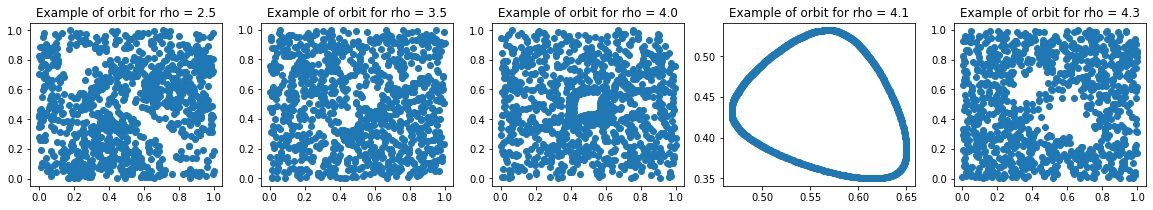

In [5]:
point_clouds = og.get_orbits()

import matplotlib.pyplot as plt

rho_values = [2.5, 3.5, 4.0, 4.1,4.3]
fig, ax = plt.subplots(ncols=len(rho_values), figsize = (20,3))

for i in range(len(rho_values)):
    x , y = point_clouds[i*config_data.num_orbits_per_class,:,0], point_clouds[i*config_data.num_orbits_per_class,:,1] 
    ax[i].scatter(x, y)
    ax[i].set_title('Example of orbit for rho = ' + str(rho_values[i]))


## Specify the Persformer achitecture

In [6]:
# Define the model by using a Wrapper for the Persformer model

model_config = PersformerConfig(
    input_size=2 + 2, # there are 2 coordinates and 2 homology dimensions
    ouptut_size=5,  # there are 5 classes
    hidden_size=16,
    intermediate_size=16,
    num_attention_layers=2,
    num_attention_heads=8,
)

wrapped_model = PersformerWrapper(
    num_attention_layers=2,
    num_attention_heads=8,
    input_size= 2 + 2,
    output_size=5,
    pooler_type=PoolerType.ATTENTION,
    hidden_size=16,
    intermediate_size=16,
)

# Define the trainer 

writer = GiottoSummaryWriter()

loss_function =  nn.CrossEntropyLoss()

trainer = Trainer(wrapped_model, [dl_train, dl_train], loss_function, writer) 




## We are ready to train Persformer!

In [7]:
# train the model for one epoch

n_epoch = 1

trainer.train(Adam, n_epoch)

Epoch 1
-------------------------------


/home/berkouknicolas/giotto-deep/gdeep/trainer/trainer.py:313: UserWarning:

The histogram is empty, most likely because your loss is exploding. Try use gradient clipping.



Epoch training loss:      nan 	Epoch training accuracy: 21.09%                                      
Time taken for this epoch: 2.00s
Learning rate value: 0.00100000
Validation results: 
 accuracy: 15.62%,                 Avg loss:      nan 



/home/berkouknicolas/giotto-deep/gdeep/trainer/trainer.py:455: UserWarning:

Cannot store data in the PR curve

/home/berkouknicolas/giotto-deep/gdeep/trainer/trainer.py:411: UserWarning:

The histogram is empty, most likely because your loss is exploding. Try use gradient clipping.



(nan, 15.625)

/home/berkouknicolas/.local/lib/python3.9/site-packages/captum/_utils/gradient.py:56: UserWarning:

Input Tensor 0 did not already require gradients, required_grads has been set automatically.



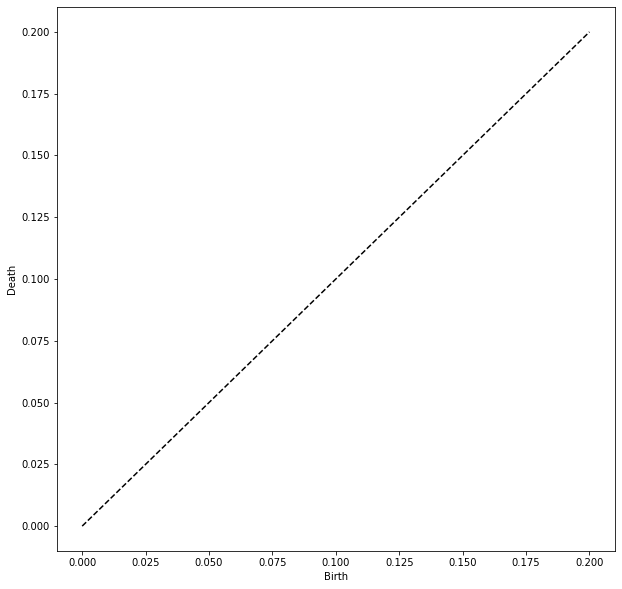

In [8]:
# get a datum and its corresponding class
batch = next(iter(dl_train))
datum = batch[0][0].reshape(1, *(batch[0][0].shape))
class_ = batch[1][0].item()

# we now the Saliency maps to interpret the results
inter = Interpreter(trainer.model, method="Saliency")

# interpret the diagram
x, attr = inter.interpret(x=datum, y=class_)

# visualise the results
vs = Visualiser(trainer)
vs.plot_attributions_persistence_diagrams(inter)


In [ ]:
# initialise hpo object
search = HyperParameterOptimization(trainer, "accuracy", 2, best_not_last=True)

# if you want to store pickle files of the models instead of the state_dicts
search.store_pickle = True

# dictionaries of hyperparameters
optimizers_params = {"lr": [0.001, 0.01]}
dataloaders_params = {"batch_size": [2, 4, 2]}
models_hyperparams = {
    "input_size": [4],
    "output_size": [5],
    "num_attention_layers": [1, 2, 1],
    "num_attention_heads": [8, 16, 8],
    "hidden_size": [16],
    "intermediate_size": [16],
}

# starting the HPO
search.start(
    [Adam],
    1,
    False,
    optimizers_params,
    dataloaders_params,
    models_hyperparams,
)

